Ion simulation

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import json

from PyonDetect.ion.ion import Ion, BerylliumIon, CalciumIon
from PyonDetect.estimator.estimator import EntropyGainEstimator, MinExpectedBinsEstimator, ThresholdingEstimator, AdaptiveMLEstimator, NonPoissonianAdaptiveMLEstimator
from PyonDetect.environment.environment import SimulationEnvironment

In [3]:
# initialize simulation environment
R_D = 0.1 / 200 # per us
R_B = 25 / 200 #per us
initial_state = 0 # bright
n_subbins = 25
t_detection = 200 # us

ion = Ion(initial_state, R_dark=R_D, R_bright=R_B)
estimator = EntropyGainEstimator(R_D=R_D, R_B=R_B, e_c=1e-4, n_subbins_max=n_subbins, n_counts_max = 10, save_trajectory=True)
env = SimulationEnvironment([ion], [estimator], detection_time=t_detection, n_subbins=n_subbins, n_repetition=10000)

In [4]:
# let simulation run
env.run()

In [5]:
# save data to files
env.save_to_csv()
env.save_to_json()

In [60]:
# Opening trajectory JSON file
f = open('n_subbins=25.json')
binned_traj = json.loads(json.load(f))

n_pi_per_subbin = np.zeros(25)
p_b_avg_per_subbin = np.zeros(25)
n_est_left_per_subbin = np.zeros(25)

n_repetition = 10000
subbin_idx = np.arange(1, 26, 1)

for traj_i in binned_traj.keys():
    # get sub dict
    subdict = binned_traj[traj_i]
    p = subdict['probability']
    pi_pulse_traj = subdict['pi_pulse_0']
    p_b_traj = subdict['p_b_0']
    for i in range(len(p_b_traj)):
        n_pi_per_subbin[i] += p * n_repetition * pi_pulse_traj[i]
        n_est_left_per_subbin[i] += p * n_repetition
        p_b_avg_per_subbin[i] += p_b_traj[i]

idx_not_zero = np.argwhere(n_est_left_per_subbin != 0)
p_b_avg_per_subbin = p_b_avg_per_subbin[idx_not_zero] / n_est_left_per_subbin[idx_not_zero]
n_est_left_per_subbin = n_est_left_per_subbin[idx_not_zero]
subbin_idx = subbin_idx[idx_not_zero]
n_pi_per_subbin = n_pi_per_subbin[idx_not_zero]

Text(0.5, 0, 'subbin index')

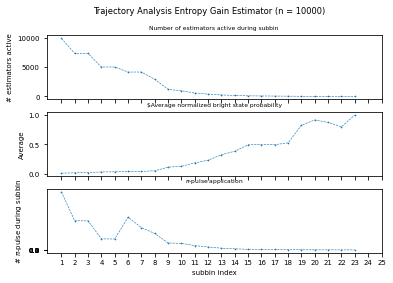

In [61]:
fig, axs = plt.subplots(3, 1, sharex='col')
plt.rc('font', size=7)  
plt.rc('axes', titlesize=6)
linewidth = 0.6
size = 2

fig.suptitle('Trajectory Analysis Entropy Gain Estimator (n = 10000)')
axs[0].set_title('Number of estimators active during subbin')
axs[0].plot(subbin_idx, n_est_left_per_subbin, linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[0].set_ylabel('# estimators active')


axs[2].set_title('$\pi$-pulse application')
axs[2].plot(subbin_idx, n_pi_per_subbin, linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[2].set_ylabel('# $\pi$-pulse during subbin')


axs[1].set_title('$Average normalized bright state probability')
axs[1].plot(subbin_idx, p_b_avg_per_subbin, linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[1].set_ylabel('Average')
axs[2].set_yticks(np.arange(0, 1.1, 0.2))
axs[2].set_xticks(np.arange(1, 26, 1))
axs[2].set_xlabel('subbin index')



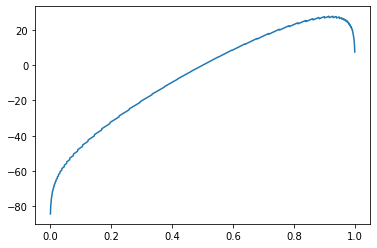

In [82]:
## some fun
e_c = 1e-4
ln_beta_ec = np.log((1 - e_c) / e_c)
R_B = 10 / 200 # per us
R_D = 1 / 200 # per us
delta_R = R_B - R_D

t_bin = 4
def alpha(R_B, t_bin):
    a = np.exp(-R_B * t_bin)
    coeff_alpha = 1 / (1 - a)
    return coeff_alpha

p_b = np.linspace(0.001, 0.999, 1000)
def decision(p_b, R_B, t_bin):
    return (1 - 2 * p_b) * (alpha(R_B, t_bin) - np.ceil((ln_beta_ec - np.log(p_b / (1-p_b))) / (delta_R * t_bin)))
plt.plot(p_b, decision(p_b, R_B, t_bin))
threshold_idx = np.argwhere(decision(p_b, R_B, t_bin) < 0)

In [ ]:
t_detection = 200
n_bins = np.arange(5, 30)
print(n_bins)
t_bin = t_detection / n_bins
print(t_bin)
plt.scatter(200/t_bin, t_bin * alpha(R_B, t_bin))
print(200/t_bin, t_bin * alpha(R_B, t_bin))

In [42]:
# run test

def run_environment(n_bins, initial_state):
    R_D = 0 / 200 # per us
    R_B = 25 / 200 # per us
    e_c = 1e-4
    t_detection = 200
    ions = [Ion(initial_state, R_dark=R_D, R_bright=R_B) for i in range(3)]
    estimator1 = MinExpectedBinsEstimator(R_D=R_D, R_B=R_B, e_c=e_c, n_subbins_max=n_bins, save_trajectory=False)
    estimator2 = AdaptiveMLEstimator(R_D=R_D, R_B=R_B, e_c=e_c, n_subbins_max=n_bins, save_trajectory=False)
    estimator3 = EntropyGainEstimator(R_D=R_D, R_B=R_B, e_c=e_c, n_subbins_max=n_bins, n_counts_max=10, save_trajectory=False)
    estimators = [estimator1, estimator2, estimator3]
    env = SimulationEnvironment(ions, estimators, detection_time=t_detection, n_subbins=n_bins, n_repetition=100)
    env.run()
    env.save_to_csv()

In [2]:
import pandas as pd
import numpy as np

In [23]:
idx = np.arange(5, 36)
print(len(idx))
paths = ['./detection_sim/outputs/dark_R_D_0/',
         './detection_sim/outputs/bright_R_D_0/',
         './detection_sim/outputs/dark_R_D_0_1/',
         './detection_sim/outputs/bright_R_D_0_1/']

31


In [24]:
def load_data(path, idx):
    filename = 'n_subbins='+str(int(idx))+'.csv'
    df = pd.read_csv(path + filename)
    return df

In [32]:
n_subbins_avg_dark_R_D_0 = np.zeros((len(idx), 3))
t_detection_avg_dark_R_D_0 = np.zeros((len(idx), 3))
n_errors_dark_R_D_0 = np.zeros((len(idx), 3))
n_pi_pulse_avg_dark_R_D_0 = np.zeros((len(idx), 3))

n_subbins_avg_dark_R_D_0_1 = np.zeros((len(idx), 3))
t_detection_avg_dark_R_D_0_1 = np.zeros((len(idx), 3))
n_errors_dark_R_D_0_1 = np.zeros((len(idx), 3))
n_pi_pulse_avg_dark_R_D_0_1 = np.zeros((len(idx), 3))

n_subbins_avg_bright_R_D_0 = np.zeros((len(idx), 3))
t_detection_avg_bright_R_D_0 = np.zeros((len(idx), 3))
n_errors_bright_R_D_0 = np.zeros((len(idx), 3))
n_pi_pulse_avg_bright_R_D_0 = np.zeros((len(idx), 3))

n_subbins_avg_bright_R_D_0_1 = np.zeros((len(idx), 3))
t_detection_avg_bright_R_D_0_1 = np.zeros((len(idx), 3))
n_errors_bright_R_D_0_1 = np.zeros((len(idx), 3))
n_pi_pulse_avg_bright_R_D_0_1 = np.zeros((len(idx), 3))

In [33]:
for j, i in enumerate(idx):
    df = load_data(paths[0], i)
    for l in range(3):
        n_subbins_avg = np.mean(df['n_subbins_' + str(l)].to_numpy())
        t_detection_avg = (200 / i) * n_subbins_avg
        n_errors = len(df['prediction_' + str(l)].to_numpy()) - np.sum(df['prediction_' + str(l)].to_numpy())
        n_subbins_avg_dark_R_D_0[j, l] = n_subbins_avg
        t_detection_avg_dark_R_D_0[j, l] = t_detection_avg
        n_errors_dark_R_D_0[j, l] = n_errors
        if l != 1:
            n_pi_pulse_avg_dark_R_D_0[j, l] = np.mean(df['n_pi_pulses_' + str(l)].to_numpy())
        
    df = load_data(paths[1], i)
    for l in range(3):
        n_subbins_avg = np.mean(df['n_subbins_' + str(l)].to_numpy())
        t_detection_avg = (200 / i) * n_subbins_avg
        n_errors = np.sum(df['prediction_' + str(l)].to_numpy())
        n_subbins_avg_bright_R_D_0[j, l] = n_subbins_avg
        t_detection_avg_bright_R_D_0[j, l] = t_detection_avg
        n_errors_bright_R_D_0[j, l] = n_errors
        if l != 1:
            n_pi_pulse_avg_bright_R_D_0[j, l] = np.mean(df['n_pi_pulses_' + str(l)].to_numpy())
        
    df = load_data(paths[2], i)
    for l in range(3):
        n_subbins_avg = np.mean(df['n_subbins_' + str(l)].to_numpy())
        t_detection_avg = (200 / i) * n_subbins_avg
        n_errors = len(df['prediction_' + str(l)].to_numpy()) - np.sum(df['prediction_' + str(l)].to_numpy())
        n_subbins_avg_dark_R_D_0_1[j, l] = n_subbins_avg
        t_detection_avg_dark_R_D_0_1[j, l] = t_detection_avg
        n_errors_dark_R_D_0_1[j, l] = n_errors
        if l != 1:
            n_pi_pulse_avg_dark_R_D_0_1[j, l] = np.mean(df['n_pi_pulses_' + str(l)].to_numpy())
        
    df = load_data(paths[3], i)
    for l in range(3):
        n_subbins_avg = np.mean(df['n_subbins_' + str(l)].to_numpy())
        t_detection_avg = (200 / i) * n_subbins_avg
        n_errors = np.sum(df['prediction_' + str(l)].to_numpy())
        n_subbins_avg_bright_R_D_0_1[j, l] = n_subbins_avg
        t_detection_avg_bright_R_D_0_1[j, l] = t_detection_avg
        n_errors_bright_R_D_0_1[j, l] = n_errors
        if l != 1:
            n_pi_pulse_avg_bright_R_D_0_1[j, l] = np.mean(df['n_pi_pulses_' + str(l)].to_numpy())

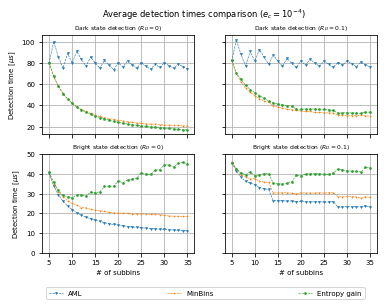

In [174]:
# plotting fun detection time

fig, axs = plt.subplots(2, 2, sharex='all', sharey='row')
plt.rc('font', size=7)  
plt.rc('axes', titlesize=6)
linewidth = 0.6
size = 2
fig.suptitle('Average detection times comparison ($e_c = 10^{-4}$)')
# plot top left (dark detection R_D = 0)
axs[0, 0].set_title('Dark state detection ($R_D = 0$)')
axs[0, 0].plot(idx, t_detection_avg_dark_R_D_0[:, 1], label='AML', linewidth = linewidth, linestyle='--', marker = 'v', markersize=size, mew=linewidth)
axs[0, 0].plot(idx, t_detection_avg_dark_R_D_0[:, 0], label='MinBins', linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[0, 0].plot(idx, t_detection_avg_dark_R_D_0[:, 2], label='Entropy gain',linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[0, 0].set_ylabel('Detection time $[\mu s$]')
axs[0, 0].set_xticks(np.arange(5, 36, 5))
axs[0, 0].grid('all')



# plot top right (dark detection R_D = 0.1)
axs[0, 1].set_title('Dark state detection ($R_D = 0.1$)')
axs[0, 1].plot(idx, t_detection_avg_dark_R_D_0_1[:, 1], label='AML', linewidth = linewidth, linestyle='--', marker = 'v', markersize=size, mew=linewidth)
axs[0, 1].plot(idx, t_detection_avg_dark_R_D_0_1[:, 0], label='MinBins', linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[0, 1].plot(idx, t_detection_avg_dark_R_D_0_1[:, 2], label='Entropy gain', linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[0, 1].grid('all')

# plot bottom left (dark detection R_D = 0.1)
axs[1, 0].set_title('Bright state detection ($R_D = 0$)')
axs[1, 0].plot(idx, t_detection_avg_bright_R_D_0[:, 1], label='AML', linewidth = linewidth, linestyle='--', marker = 'v', markersize=size, mew=linewidth)
axs[1, 0].plot(idx, t_detection_avg_bright_R_D_0[:, 0], label='MinBins',linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[1, 0].plot(idx, t_detection_avg_bright_R_D_0[:, 2], label='Entropy gain', linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[1, 0].set_xlabel('# of subbins')
axs[1, 0].set_ylabel('Detection time $[\mu s$]')
axs[1, 0].grid('all')
axs[1, 0].legend(loc='lower left', ncol=3, columnspacing=12, bbox_to_anchor=(0.0, -0.5))

# plot bottom right(dark detection R_D = 0.1)
axs[1, 1].set_title('Bright state detection ($R_D = 0.1$)')
axs[1, 1].plot(idx, t_detection_avg_bright_R_D_0_1[:, 1], label='AML', linewidth = linewidth, linestyle='--', marker = 'v', markersize=size, mew=linewidth)
axs[1, 1].plot(idx, t_detection_avg_bright_R_D_0_1[:, 0], label='MinBins',linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[1, 1].plot(idx, t_detection_avg_bright_R_D_0_1[:, 2], label='Entropy gain', linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[1, 1].set_xlabel('# of subbins')
axs[1, 1].set_yticks(np.arange(0, 60, 10))
axs[1, 1].grid('all')

fig.savefig("avg_t_det.pdf", bbox_inches='tight')

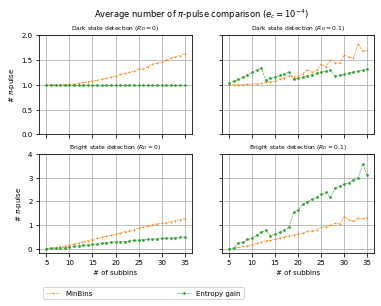

In [173]:
fig, axs = plt.subplots(2, 2, sharex='all', sharey='row')
plt.rc('font', size=7)  
plt.rc('axes', titlesize=6)
linewidth = 0.6
size = 2
fig.suptitle('Average number of $\pi$-pulse comparison ($e_c = 10^{-4}$)')
# plot top left (dark detection R_D = 0)
axs[0, 0].set_title('Dark state detection ($R_D = 0$)')
axs[0, 0].plot(idx, n_pi_pulse_avg_dark_R_D_0[:, 0], color='tab:orange', label='MinBins', linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[0, 0].plot(idx, n_pi_pulse_avg_dark_R_D_0[:, 2], color='tab:green', label='Entropy gain',linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[0, 0].set_ylabel('# $\pi$-pulse')
axs[0, 0].set_xticks(np.arange(5, 36, 5))
axs[0, 0].grid('all')



# plot top right (dark detection R_D = 0.1)
axs[0, 1].set_title('Dark state detection ($R_D = 0.1$)')
axs[0, 1].plot(idx, n_pi_pulse_avg_dark_R_D_0_1[:, 0], color='tab:orange', label='MinBins', linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[0, 1].plot(idx, n_pi_pulse_avg_dark_R_D_0_1[:, 2], color='tab:green', label='Entropy gain', linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[0, 1].set_yticks(np.arange(0, 2.5, 0.5))
axs[0, 1].grid('all')

# plot bottom left (dark detection R_D = 0.1)
axs[1, 0].set_title('Bright state detection ($R_D = 0$)')
axs[1, 0].plot(idx, n_pi_pulse_avg_bright_R_D_0[:, 0], color='tab:orange', label='MinBins',linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[1, 0].plot(idx, n_pi_pulse_avg_bright_R_D_0[:, 2], color='tab:green', label='Entropy gain', linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[1, 0].set_xlabel('# of subbins')
axs[1, 0].set_ylabel('# $\pi$-pulse')
axs[1, 0].grid('all')
axs[1, 0].legend(loc='lower left', ncol=3, columnspacing=12, bbox_to_anchor=(0.0, -0.5))

# plot bottom right(dark detection R_D = 0.1)
axs[1, 1].set_title('Bright state detection ($R_D = 0.1$)')
axs[1, 1].plot(idx, n_pi_pulse_avg_bright_R_D_0_1[:, 0], color='tab:orange', label='MinBins',linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[1, 1].plot(idx, n_pi_pulse_avg_bright_R_D_0_1[:, 2], color='tab:green', label='Entropy gain', linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[1, 1].set_xlabel('# of subbins')
axs[1, 1].set_yticks(np.arange(0, 5, 1))
axs[1, 1].grid('all')

fig.savefig("avg_n_Pi.pdf", bbox_inches='tight')

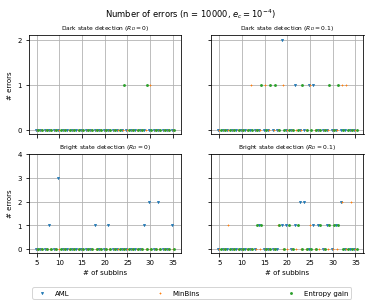

In [189]:
# plotting fun errors

fig, axs = plt.subplots(2, 2, sharex='all', sharey='row')
plt.rc('font', size=7)  
plt.rc('axes', titlesize=6)
linewidth = 0.8
size = 4
fig.suptitle('Number of errors (n = 10000, $e_c = 10^{-4})$')
# plot top left (dark detection R_D = 0)
axs[0, 0].set_title('Dark state detection ($R_D = 0$)')
axs[0, 0].scatter(idx - 0.25, n_errors_dark_R_D_0[:, 1], label='AML', linewidths = linewidth, marker = 'v', s=size)
axs[0, 0].scatter(idx, n_errors_dark_R_D_0[:, 0], label='MinBins', linewidths = linewidth, marker = '+', s=size)
axs[0, 0].scatter(idx + 0.25, n_errors_dark_R_D_0[:, 2], label='Entropy gain',linewidths = linewidth, marker = 'o',s=size)
axs[0, 0].set_ylabel('# errors')
axs[0, 0].set_xticks(np.arange(5, 36, 5))
axs[0, 0].grid('row')
axs[0, 0].set_axisbelow(True)


# plot top right (dark detection R_D = 0.1)
axs[0, 1].set_title('Dark state detection ($R_D = 0.1$)')
axs[0, 1].scatter(idx - 0.25, n_errors_dark_R_D_0_1[:, 1], label='AML', linewidths = linewidth, marker = 'v', s=size)
axs[0, 1].scatter(idx, n_errors_dark_R_D_0_1[:, 0], label='MinBins', linewidths = linewidth, marker = '+', s=size)
axs[0, 1].scatter(idx + 0.25, n_errors_dark_R_D_0_1[:, 2], label='Entropy gain', linewidths = linewidth, marker = 'o', s=size)
axs[0, 0].set_yticks(np.arange(0, 3, 1))
axs[0, 1].grid('row')
axs[0, 1].set_axisbelow(True)

# plot bottom left (dark detection R_D = 0.1)
axs[1, 0].set_title('Bright state detection ($R_D = 0$)')
axs[1, 0].scatter(idx - 0.25, n_errors_bright_R_D_0[:, 1], label='AML', linewidths = linewidth, marker = 'v', s=size)
axs[1, 0].scatter(idx, n_errors_bright_R_D_0[:, 0], label='MinBins',linewidths = linewidth, marker = '+', s=size)
axs[1, 0].scatter(idx + 0.25, n_errors_bright_R_D_0[:, 2], label='Entropy gain', linewidths = linewidth, marker = 'o', s=size)
axs[1, 0].set_xlabel('# of subbins')
axs[1, 0].set_ylabel('# errors')
axs[1, 0].set_axisbelow(True)
axs[1, 0].grid('row')
axs[1, 0].legend(loc='lower left', ncol=3, columnspacing=12, bbox_to_anchor=(0.0, -0.5))

# plot bottom right(dark detection R_D = 0.1)
axs[1, 1].set_title('Bright state detection ($R_D = 0.1$)')
axs[1, 1].set_axisbelow(True)
axs[1, 1].grid('row')
axs[1, 1].scatter(idx - 0.25, n_errors_bright_R_D_0_1[:, 1], label='AML', linewidths = linewidth, marker = 'v', s=size)
axs[1, 1].scatter(idx, n_errors_bright_R_D_0_1[:, 0], label='MinBins',linewidths = linewidth, marker = '+', s=size)
axs[1, 1].scatter(idx + 0.25, n_errors_bright_R_D_0_1[:, 2], label='Entropy gain', linewidths = linewidth, marker = 'o', s=size)
axs[1, 1].set_xlabel('# of subbins')
axs[1, 1].set_yticks(np.arange(0, 5, 1))


fig.savefig("errors.pdf", bbox_inches='tight')

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, entropy

def entropy_diff_n(mu_D, mu_B, p_b, n):
    p_i_dark = poisson.pmf(n, mu_D)
    p_i_bright = poisson.pmf(n, mu_B)

    # no Pi
    p_D_no_Pi = (1 - p_b) * p_i_dark
    p_B_no_Pi = p_b * p_i_bright

    # pi
    p_D_Pi = (1 - p_b) * p_i_bright
    p_B_Pi = p_b * p_i_dark

    # return weighted difference
    return (p_i_dark + p_i_bright) * (entropy([p_D_Pi, p_B_Pi]) - entropy([p_D_no_Pi, p_B_no_Pi]))

def entropy_diff(mu_D, mu_B, n_max, p_b):
    H_diff = 0
    for i in range(n_max):
        # add
        H_diff_n_weighted = entropy_diff_n(mu_D, mu_B, p_b, i)
        H_diff+= H_diff_n_weighted
        
    return H_diff
    

Text(0.5, 1.0, 'Entropy difference n_bins = 30')

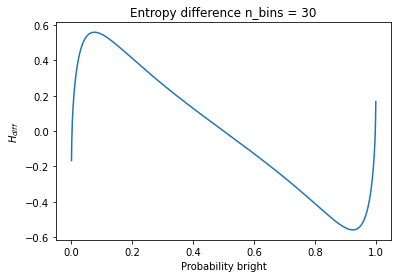

In [11]:
n_bins = 10
t_bin = 200 / n_bins
R_D = 0.1 / 200
R_B = 25 / 200

mu_D = t_bin * R_D
mu_B = t_bin * (R_D + R_B)

n_max = 10

p_b = np.linspace(0.0001, 0.9999, 200)
H_diff = [entropy_diff(mu_D, mu_B, n_max, p) for p in p_b]
plt.plot(p_b, H_diff)
plt.xlabel('Probability bright')
plt.ylabel('$H_{diff}$')
plt.title('Entropy difference n_bins = 30')


1.0

array([ 0, 10, 20, 30, 40, 50, 60])